<a href="https://colab.research.google.com/github/cormac-black/chekhovs-biscuit/blob/main/Copy_of_back_at_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2


Needed ChatGPT help with overlay_it. I had issues with image.shape and # of layers. I made numpy grumpy.

Original, dtype=uint8,shape=(500, 333, 3)



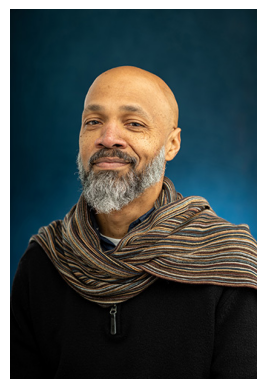


 Display, dtype=uint8,shape=(500, 333, 3)



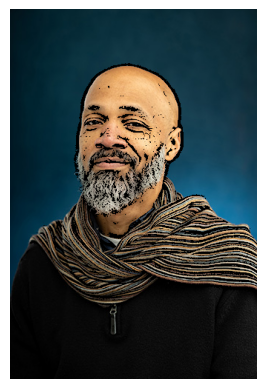


 Display, dtype=uint8,shape=(500, 333, 3)



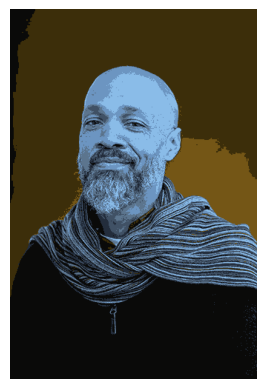


 Display, dtype=uint8,shape=(500, 333, 3)



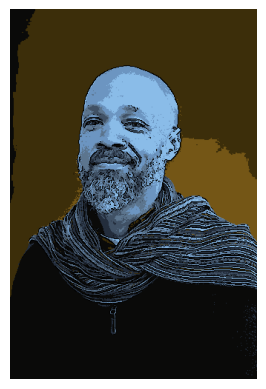


 Display, dtype=uint8,shape=(500, 333, 3)



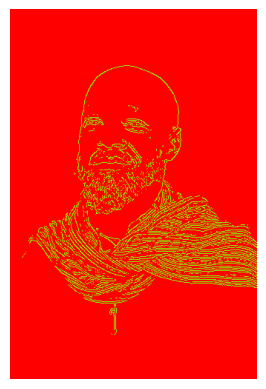


 Display, dtype=uint8,shape=(500, 333, 3)



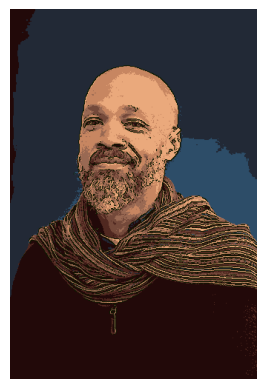

In [5]:
from PIL.Image import composite


img_path = '/content/headshot.jpg' # cv2 starts with image path
img_raw = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

def display_img(img, title="Image"):

  plt.imshow(img)
  plt.axis('off')
  print(f'\n Display, dtype={img.dtype},shape={img.shape}\n')
  plt.show()

def overlay_it(img):
    # Read background
    bg = cv2.imread(img_path)
    bg = cv2.cvtColor (bg, cv2.COLOR_BGR2RGB) ## << put posterized here instead of bg
    if bg is None:
        print(f"Image not found at: {img_path}")
        return None

    # Convert background image to grayscale for edge detection
    gray = cv2.cvtColor(bg, cv2.COLOR_BGR2GRAY)

    # Edge detection
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 15, 18) ## second to last number must be odd !!

    # White mask (white = 255, transparent areas)
    white_mask = (edges == 255)
    alpha = (~white_mask).astype(np.uint8) * 255  # alpha=255 where edge is black

    # Convert edges to an RGB image
    edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Stack to make RGBA
    rgba = np.dstack([edges_rgb, alpha])

    # Resize overlay to match background, SHIT...
    if rgba.shape[:2] != bg.shape[:2]:
        rgba = cv2.resize(rgba, (bg.shape[1], bg.shape[0]))

    # Prepare for blending
    foreground = rgba.astype(float) / 255.0
    background = bg.astype(float) / 255.0
    alpha_channel = foreground[..., 3][..., None]

    # Blend!
    composite = alpha_channel * foreground[..., :3] + (1.0 - alpha_channel) * background
    composite = (composite * 255).astype(np.uint8)

    return composite, edges

def posterize_it(img):

  pixel_values = img_raw.reshape((-1, 3))
  pixel_values = np.float32(pixel_values)
  k = 8
  _, labels, centers = cv2.kmeans(pixel_values, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, .2), 10, cv2.KMEANS_RANDOM_CENTERS)
  centers = np.uint8(centers)

  quantized_img = centers[labels.flatten()]
  quantized_img = quantized_img.reshape(img_raw.shape)

  return quantized_img

def find_edges(img):
  img_GRAY = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
  edges1 = cv2.Canny(img_GRAY, 230, 240)
  kernel = np.ones((1,1), np.uint8) # gaussian kernel = border thickess
  dilated_edges = cv2.dilate(edges1, kernel, iterations=1) # edges or edges1 ???

  result = quantized_img.copy()
  result[dilated_edges !=0] = [0,0,0]

  img_GRAY_blur = cv2.medianBlur(img_GRAY, 3) # Changed ksize from 1 to 3 based on original comment's implied intent

  img_filtered = cv2.applyColorMap(dilated_edges, cv2.COLORMAP_WINTER) # MAGMA

  return result, img_filtered

def add_Weighted(img1, img2):

  alpha = 0.9
  beta = 0.1
  gamma = 0 # brightness; gamma max -/+100, else whiteout, blackout

  blended_img = cv2.addWeighted(cv2.cvtColor(result, cv2.COLOR_BGR2RGB), alpha, img_filtered, beta, gamma)

  return blended_img

image = mping.imread('/content/headshot.jpg')
plt.imshow(image)
plt.axis('off')
print(f'Original, dtype={image.dtype},shape={image.shape}\n')
plt.show()


composite, edges = overlay_it(img_raw)
if composite is None:
  raise FileNotFoundError(f'Could not load image from {img_path}')
display_img(composite, "Composite with edges overlay")

quantized_img = posterize_it(composite)
display_img(quantized_img, 'Posterized image')


result, img_filtered = find_edges(quantized_img)
display_img(result, 'Result (edges masked to black)')
display_img(img_filtered, 'Filtered edges (Colormap)')

if result.shape[-1] == 3:
  result_rgb = result
else:
  result_rgb = result[..., :3]

da_pic = add_Weighted(result_rgb, img_filtered)

display_img(da_pic, 'Blended Final Output')